# Text Classification and Data Sets

:label:`chapter_sentiment`


Text classification is a common task in natural language processing, which transforms a sequence of text of indefinite length into a category of text. It's similar to the image classification, the most frequently used application in this book, e.g. :numref:`chapter_naive_bayes`. The only difference is that, rather than an image, text classification's example is a text sentence. 

This section will focus on loading data for one of the sub-questions in this field: using text sentiment classification to analyze the emotions of the text's author. This problem is also called sentiment analysis and has a wide range of applications. For example, we can analyze user reviews of products to obtain user satisfaction statistics, or analyze user sentiments about market conditions and use it to predict future trends.

In [1]:
import d2l
from mxnet import gluon, nd
import os
import tarfile

## Text Sentiment Classification Data

We use Stanford's Large Movie Review Dataset as the data set for text sentiment classification[1]. This data set is divided into two data sets for training and testing purposes, each containing 25,000 movie reviews downloaded from IMDb. In each data set, the number of comments labeled as "positive" and "negative" is equal.

###  Reading Data

We first download this data set to the "../data" path and extract it to "../data/aclImdb".

In [2]:
# Save to the d2l package.
def download_imdb(data_dir='../data'):
    url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    fname = gluon.utils.download(url, data_dir)
    with tarfile.open(fname, 'r') as f:
        f.extractall(data_dir)
        
download_imdb()

Next, read the training and test data sets. Each example is a review and its corresponding label: 1 indicates "positive" and 0 indicates "negative".

In [3]:
# Save to the d2l package.
def read_imdb(folder='train', data_dir='../data'):
    data, labels = [], []
    for label in ['pos', 'neg']:
        folder_name = os.path.join(data_dir, 'aclImdb', folder, label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb('train')
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[0:60])

# trainings: 25000
label: 1 review: Normally the best way to annoy me in a film is to include so
label: 1 review: The Bible teaches us that the love of money is the root of a
label: 1 review: Being someone who lists Night of the Living Dead at number t


### Tokenization and Vocabulary

We use a word as a token, and then create a dictionary based on the training data set.

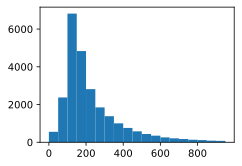

In [4]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5)

d2l.set_figsize((3.5, 2.5))
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0,1000,50));

### Padding to the Same Length

Because the reviews have different lengths, so they cannot be directly combined into mini-batches. Here we fix the length of each comment to 500 by truncating or adding "&lt;unk&gt;" indices.

In [5]:
num_steps = 500  # sequence length
train_features = nd.array([d2l.trim_pad(vocab[line], num_steps, vocab.unk) 
                          for line in train_tokens])
train_features.shape

(25000, 500)

### Create Data Iterator

Now, we will create a data iterator. Each iteration will return a mini-batch of data.

In [6]:
train_iter = d2l.load_array((train_features, train_data[1]), 64)

for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break
'# batches:', len(train_iter)

X (64, 500) y (64,)


('# batches:', 391)

## Put All Things Together

Lastly, we will save a function `load_data_imdb` into `d2l`, which returns the vocabulary and data iterators.

In [7]:
# Save to the d2l package.
def load_data_imdb(batch_size, num_steps=500):
    download_imdb()
    train_data, test_data = read_imdb('train'), read_imdb('test')
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = nd.array([d2l.trim_pad(vocab[line], num_steps, vocab.unk) 
                               for line in train_tokens])
    test_features = nd.array([d2l.trim_pad(vocab[line], num_steps, vocab.unk) 
                               for line in test_tokens])
    train_iter = d2l.load_array((train_features, train_data[1]), batch_size)
    test_iter = d2l.load_array((test_features, test_data[1]), batch_size, 
                               is_train=False)
    return train_iter, test_iter, vocab

## Summary

# Text Sentiment Classification: Using a Bag of Context Free Embeddings

In [1]:
import d2l
import mxnet as mx
from mxnet import gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, rnn, utils as gutils
import gluonnlp as nlp
import os
import tarfile

## Text Sentiment Classification Data

###  Reading Data

In [2]:
data_dir = './'
url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
fname = gutils.download(url, data_dir)
with tarfile.open(fname, 'r') as f:
    f.extractall(data_dir)

Read the training and test data sets.

In [3]:
def read_imdb(folder='train'):
    data, labels = [], []
    for label in ['pos', 'neg']:
        folder_name = os.path.join(data_dir, 'aclImdb', folder, label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data, test_data = read_imdb('train'), read_imdb('test')
print('# trainings:', len(train_data[0]), '\n# tests:', len(test_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[0:60])

# trainings: 25000 
# tests: 25000
label: 1 review: I couldn't believe the comments made about the movie.<br /><
label: 1 review: Deanna Durbin, then 14 and just under contract to MGM, made 
label: 1 review: ...may seem like an overstatement, but it is not.<br /><br /


### Tokenization and Vocabulary 



In [4]:
def tokenize(sentences):
    return [line.split(' ') for line in sentences]

train_tokens = tokenize(train_data[0])
test_tokens = tokenize(test_data[0])

import itertools
vocab = nlp.Vocab(nlp.data.count_tokens(
    itertools.chain.from_iterable(line for line in train_tokens)),
    min_freq=5)

### Padding to the Same Length


In [5]:
max_len = 500

def pad(x):
    if len(x) > max_len:        
        return x[:max_len]
    else:
        return x + [vocab[vocab.unknown_token]] * (max_len - len(x))
    
train_features = nd.array([pad(vocab[line]) for line in train_tokens])
test_features = nd.array([pad(vocab[line]) for line in test_tokens])

### Create Data Iterator

In [6]:
batch_size = 256
train_set = gdata.ArrayDataset(train_features, train_data[1])
test_set = gdata.ArrayDataset(test_features, test_data[1])
train_iter = gdata.DataLoader(train_set, batch_size, shuffle=True)
test_iter = gdata.DataLoader(test_set, batch_size)

Print the shape of the first mini-batch of data and the number of mini-batches in the training set.

In [7]:
for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break
'# batches:', len(train_iter)

X (256, 500) y (256,)


('# batches:', 98)


## Average Embeddings of a Sentence

In [8]:
class ContinuousBagOfWords(nn.HybridBlock):
    def __init__(self, vocab_size, embed_size, **kwargs):
        super(ContinuousBagOfWords, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.HybridLambda(lambda F, x: F.mean(x, axis=1))
        self.decoder = nn.Dense(2)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words).
        embeddings = self.embedding(inputs)
        encoding = self.encoder(embeddings)
        outputs = self.decoder(encoding)
        return outputs

Create a the model.

In [9]:
embed_size, ctx = 100, mx.gpu(0)
net = ContinuousBagOfWords(len(vocab), embed_size)
net.hybridize()
net.initialize(init.Xavier(), ctx=ctx)

### Load Pre-trained Word Vectors


In [10]:
glove_embedding = nlp.embedding.create('glove', source='glove.6B.100d')
idx_to_vec = glove_embedding[vocab.idx_to_token]
idx_to_vec.shape

(49342, 100)

Use these word vectors as feature vectors for each word in the reviews. 

In [11]:
net.embedding.weight.set_data(idx_to_vec)
net.embedding.collect_params().setattr('grad_req', 'null')

### Train and Evaluate the Model



In [12]:
lr, num_epochs = 0.01, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gloss.SoftmaxCrossEntropyLoss()
d2l.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs)

training on gpu(0)
epoch 1, loss 0.6678, train acc 0.628, test acc 0.673, time 1.3 sec
epoch 2, loss 0.6292, train acc 0.689, test acc 0.696, time 1.0 sec
epoch 3, loss 0.6079, train acc 0.704, test acc 0.707, time 1.0 sec
epoch 4, loss 0.5911, train acc 0.717, test acc 0.715, time 1.0 sec
epoch 5, loss 0.5783, train acc 0.729, test acc 0.723, time 1.0 sec


Define the prediction function.

In [13]:
def predict_sentiment(net, vocab, sentence):
    sentence = nd.array(vocab[sentence.split()], ctx=d2l.try_gpu())
    label = nd.argmax(net(sentence.reshape((1, -1))), axis=1)
    return 'positive' if label.asscalar() == 1 else 'negative'

Then, use the trained model to classify the sentiments of two simple sentences.

In [14]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [15]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

# Text Sentiment Classification: Using Convolutional Neural Networks (textCNN)

:label:`chapter_sentiment_cnn`


In :numref:`chapter_cnn`, we explored how to process
two-dimensional image data with two-dimensional convolutional neural
networks. In the previous language models and text classification tasks, we
treated text data as a time series with only one dimension, and naturally, we
used recurrent neural networks to process such data. In fact, we can also treat
text as a one-dimensional image, so that we can use one-dimensional
convolutional neural networks to capture associations between adjacent
words. This section describes a groundbreaking approach to applying
convolutional neural networks to text analysis: textCNN :cite:`Kim.2014`. First, import the packages and modules required for the experiment.

In [1]:
import d2l
from mxnet import gluon, init, nd
from mxnet.contrib import text
from mxnet.gluon import nn


batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## One-dimensional Convolutional Layer

Before introducing the model, let us explain how a one-dimensional convolutional layer works. Like a two-dimensional convolutional layer, a one-dimensional convolutional layer uses a one-dimensional cross-correlation operation. In the one-dimensional cross-correlation operation, the convolution window starts from the leftmost side of the input array and slides on the input array from left to right successively. When the convolution window slides to a certain position, the input subarray in the window and kernel array are multiplied and summed by element to get the element at the corresponding location in the output array. As shown in Figure 12.4, the input is a one-dimensional array with a width of 7 and the width of the kernel array is 2. As we can see, the output width is $7-2+1=6$ and the first element is obtained by performing multiplication by element on the leftmost input subarray with a width of 2 and kernel array and then summing the results.

![One-dimensional cross-correlation operation. The shaded parts are the first output element as well as the input and kernel array elements used in its calculation: $0\times1+1\times2=2$. ](../img/conv1d.svg)

Next, we implement one-dimensional cross-correlation in the `corr1d` function. It accepts the input array `X` and kernel array `K` and outputs the array `Y`.

In [2]:
def corr1d(X, K):
    w = K.shape[0]
    Y = nd.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

Now, we will reproduce the results of the one-dimensional cross-correlation operation in Figure 12.4.

In [3]:
X, K = nd.array([0, 1, 2, 3, 4, 5, 6]), nd.array([1, 2])
corr1d(X, K)


[ 2.  5.  8. 11. 14. 17.]
<NDArray 6 @cpu(0)>

The one-dimensional cross-correlation operation for multiple input channels is also similar to the two-dimensional cross-correlation operation for multiple input channels. On each channel, it performs the one-dimensional cross-correlation operation on the kernel and its corresponding input and adds the results of the channels to get the output. Figure 12.5 shows a one-dimensional cross-correlation operation with three input channels.

![One-dimensional cross-correlation operation with three input channels. The shaded parts are the first output element as well as the input and kernel array elements used in its calculation: $0\times1+1\times2+1\times3+2\times4+2\times(-1)+3\times(-3)=2$. ](../img/conv1d-channel.svg)

Now, we reproduce the results of the one-dimensional cross-correlation operation with multi-input channel in Figure 12.5.

In [4]:
def corr1d_multi_in(X, K):
    # First, we traverse along the 0th dimension (channel dimension) of X and
    # K. Then, we add them together by using * to turn the result list into a
    # positional argument of the add_n function
    return nd.add_n(*[corr1d(x, k) for x, k in zip(X, K)])

X = nd.array([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = nd.array([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)


[ 2.  8. 14. 20. 26. 32.]
<NDArray 6 @cpu(0)>

The definition of a two-dimensional cross-correlation operation tells us that a one-dimensional cross-correlation operation with multiple input channels can be regarded as a two-dimensional cross-correlation operation with a single input channel. As shown in Figure 12.6, we can also present the one-dimensional cross-correlation operation with multiple input channels in Figure 12.5 as the equivalent two-dimensional cross-correlation operation with a single input channel. Here, the height of the kernel is equal to the height of the input.

![Two-dimensional cross-correlation operation with a single input channel. The highlighted parts are the first output element and the input and kernel array elements used in its calculation: $2\times(-1)+3\times(-3)+1\times3+2\times4+0\times1+1\times2=2$. ](../img/conv1d-2d.svg)

Both the outputs in Figure 12.4 and Figure 12.5 have only one channel. We
discussed how to specify multiple output channels in a two-dimensional
convolutional layer in
:numref:`chapter_channels`.
Similarly,
we can also specify multiple output channels in the one-dimensional
convolutional layer to extend the model parameters in the convolutional layer.


## Max-Over-Time Pooling Layer

Similarly, we have a one-dimensional pooling layer. The max-over-time pooling layer used in TextCNN actually corresponds to a one-dimensional global maximum pooling layer. Assuming that the input contains multiple channels, and each channel consists of values on different time steps, the output of each channel will be the largest value of all time steps in the channel. Therefore, the input of the max-over-time pooling layer can have different time steps on each channel.

To improve computing performance, we often combine timing examples of different lengths into a mini-batch and make the lengths of each timing example in the batch consistent by appending special characters (such as 0) to the end of shorter examples. Naturally, the added special characters have no intrinsic meaning. Because the main purpose of the max-over-time pooling layer is to capture the most important features of timing, it usually allows the model to be unaffected by the manually added characters.

## The TextCNN Model

TextCNN mainly uses a one-dimensional convolutional layer and max-over-time pooling layer. Suppose the input text sequence consists of $n$ words, and each word is represented by a $d$-dimension word vector. Then the input example has a width of $n$, a height of 1, and $d$ input channels. The calculation of textCNN can be mainly divided into the following steps:

1. Define multiple one-dimensional convolution kernels and use them to perform convolution calculations on the inputs. Convolution kernels with different widths may capture the correlation of different numbers of adjacent words.
2. Perform max-over-time pooling on all output channels, and then concatenate the pooling output values of these channels in a vector.
3. The concatenated vector is transformed into the output for each category through the fully connected layer. A dropout layer can be used in this step to deal with overfitting.

![TextCNN design. ](../img/textcnn.svg)

Figure 12.7 gives an example to illustrate the textCNN. The input here is a sentence with 11 words, with each word represented by a 6-dimensional word vector. Therefore, the input sequence has a width of 11 and 6 input channels. We assume there are two one-dimensional convolution kernels with widths of 2 and 4, and 4 and 5 output channels, respectively. Therefore, after one-dimensional convolution calculation, the width of the four output channels is $11-2+1=10$, while the width of the other five channels is $11-4+1=8$. Even though the width of each channel is different, we can still perform max-over-time pooling for each channel and concatenate the pooling outputs of the 9 channels into a 9-dimensional vector. Finally, we use a fully connected layer to transform the 9-dimensional vector into a 2-dimensional output: positive sentiment and negative sentiment predictions.

Next, we will implement a textCNN model. Compared with the previous section, in addition to replacing the recurrent neural network with a one-dimensional convolutional layer, here we use two embedding layers, one with a fixed weight and another that participates in training.

In [5]:
class TextCNN(nn.Block):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer does not participate in training
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Dense(2)
        # The max-over-time pooling layer has no weight, so it can share an
        # instance
        self.pool = nn.GlobalMaxPool1D()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.Sequential()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.add(nn.Conv1D(c, k, activation='relu'))

    def forward(self, inputs):
        # Concatenate the output of two embedding layers with shape of
        # (batch size, number of words, word vector dimension) by word vector
        embeddings = nd.concat(
            self.embedding(inputs), self.constant_embedding(inputs), dim=2)
        # According to the input format required by Conv1D, the word vector
        # dimension, that is, the channel dimension of the one-dimensional
        # convolutional layer, is transformed into the previous dimension
        embeddings = embeddings.transpose((0, 2, 1))
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, an NDArray with the shape of (batch size, channel size, 1)
        # can be obtained. Use the flatten function to remove the last
        # dimension and then concatenate on the channel dimension
        encoding = nd.concat(*[nd.flatten(
            self.pool(conv(embeddings))) for conv in self.convs], dim=1)
        # After applying the dropout method, use a fully connected layer to
        # obtain the output
        outputs = self.decoder(self.dropout(encoding))
        return outputs

Create a TextCNN instance. It has 3 convolutional layers with kernel widths of 3, 4, and 5, all with 100 output channels.

In [6]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
ctx = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
net.initialize(init.Xavier(), ctx=ctx)

### Load Pre-trained Word Vectors

As in the previous section, load pre-trained 100-dimensional GloVe word vectors and initialize the embedding layers `embedding` and `constant_embedding`. Here, the former participates in training while the latter has a fixed weight.

In [7]:
glove_embedding = text.embedding.create(
    'glove', pretrained_file_name='glove.6B.100d.txt')
embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

### Train and Evaluate the Model

Now we can train the model.

loss 0.013, train acc 0.997, test acc 0.849
3395.2 exampes/sec on [gpu(0), gpu(1)]


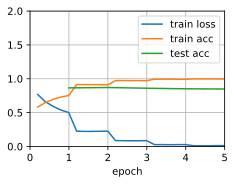

In [8]:
lr, num_epochs = 0.001, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch12(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

Below, we use the trained model to the classify sentiments of two simple sentences.

In [9]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [10]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## Summary

* We can use one-dimensional convolution to process and analyze timing data.
* A one-dimensional cross-correlation operation with multiple input channels can be regarded as a two-dimensional cross-correlation operation with a single input channel.
* The input of the max-over-time pooling layer can have different numbers of time steps on each channel.
* TextCNN mainly uses a one-dimensional convolutional layer and max-over-time pooling layer.


## Exercises

* Tune the hyper-parameters and compare the two sentiment analysis methods, using recurrent neural networks and using convolutional neural networks, as regards accuracy and operational efficiency.
* Can you further improve the accuracy of the model on the test set by using the three methods introduced in the previous section: tuning hyper-parameters, using larger pre-trained word vectors, and using the spaCy word tokenization tool?
* What other natural language processing tasks can you use textCNN for?


## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2392)

![](../img/qr_sentiment-analysis-cnn.svg)

# Text Sentiment Classification: Using Recurrent Neural Networks

:label:`chapter_sentiment_rnn`



Similar to search synonyms and analogies, text classification is also a
downstream application of word embedding. In this section, we will apply
pre-trained word vectors and bidirectional recurrent neural networks with
multiple hidden layers :cite:`Maas.Daly.Pham.ea.2011`. We will use them to
determine whether a text sequence of indefinite length contains positive or
negative emotion. Import the required package or module before starting the
experiment.

In [1]:
import d2l
from mxnet import gluon, init, nd
from mxnet.gluon import nn, rnn
from mxnet.contrib import text

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## Use a Recurrent Neural Network Model

In this model, each word first obtains a feature vector from the embedding
layer. Then, we further encode the feature sequence using a bidirectional
recurrent neural network to obtain sequence information. Finally, we transform
the encoded sequence information to output through the fully connected
layer. Specifically, we can concatenate hidden states of bidirectional
long-short term memory in the initial time step and final time step and pass it
to the output layer classification as encoded feature sequence information. In
the `BiRNN` class implemented below, the `Embedding` instance is the embedding
layer, the `LSTM` instance is the hidden layer for sequence encoding, and the
`Dense` instance is the output layer for generated classification results.

In [2]:
class BiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                bidirectional=True, input_size=embed_size)
        self.decoder = nn.Dense(2)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different time step (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
        encoding = nd.concat(outputs[0], outputs[-1])
        outs = self.decoder(encoding)
        return outs

Create a bidirectional recurrent neural network with two hidden layers.

In [3]:
embed_size, num_hiddens, num_layers, ctx = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

### Load Pre-trained Word Vectors

Because the training data set for sentiment classification is not very large, in order to deal with overfitting, we will directly use word vectors pre-trained on a larger corpus as the feature vectors of all words. Here, we load a 100-dimensional GloVe word vector for each word in the dictionary `vocab`.

In [4]:
glove_embedding = text.embedding.create(
    'glove', pretrained_file_name='glove.6B.100d.txt')

Query the word vectors that in our vocabulary.

In [5]:
embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(49339, 100)

Then, we will use these word vectors as feature vectors for each word in the reviews. Note that the dimensions of the pre-trained word vectors need to be consistent with the embedding layer output size `embed_size` in the created model. In addition, we no longer update these word vectors during training.

In [6]:
net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

### Train and Evaluate the Model

Now, we can start training.

loss 0.319, train acc 0.864, test acc 0.844
909.7 exampes/sec on [gpu(0), gpu(1)]


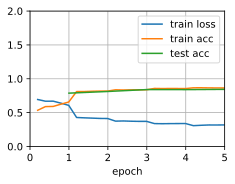

In [7]:
lr, num_epochs = 0.01, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch12(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

Finally, define the prediction function.

In [8]:
# Save to the d2l package.
def predict_sentiment(net, vocab, sentence):
    sentence = nd.array(vocab[sentence.split()], ctx=d2l.try_gpu())
    label = nd.argmax(net(sentence.reshape((1, -1))), axis=1)
    return 'positive' if label.asscalar() == 1 else 'negative'

Then, use the trained model to classify the sentiments of two simple sentences.

In [9]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [10]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## Summary

* Text classification transforms a sequence of text of indefinite length into a category of text. This is a downstream application of word embedding.
* We can apply pre-trained word vectors and recurrent neural networks to classify the emotions in a text.


## Exercises

* Increase the number of epochs. What accuracy rate can you achieve on the training and testing data sets? What about trying to re-tune other hyper-parameters?

* Will using larger pre-trained word vectors, such as 300-dimensional GloVe word vectors, improve classification accuracy?

* Can we improve the classification accuracy by using the spaCy word tokenization tool? You need to install spaCy: `pip install spacy` and install the English package: `python -m spacy download en`. In the code, first import spacy: `import spacy`. Then, load the spacy English package: `spacy_en = spacy.load('en')`. Finally, define the function `def tokenizer(text): return [tok.text for tok in spacy_en.tokenizer(text)]` and replace the original `tokenizer` function. It should be noted that GloVe's word vector uses "-" to connect each word when storing noun phrases. For example, the phrase "new york" is represented as "new-york" in GloVe. After using spaCy tokenization, "new york" may be stored as "new york".



## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2391)

![](../img/qr_sentiment-analysis-rnn.svg)

# Text Sentiment Classification: Using Recurrent Neural Networks with Self-Attention

In [1]:
import d2l
import mxnet as mx
from mxnet import gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, rnn, utils as gutils
import gluonnlp as nlp
import os
import tarfile

## Text Sentiment Classification Data

###  Reading Data

In [2]:
vocab, train_iter, test_iter = d2l.load_data_imdb(batch_size=64)

Print the shape of the first mini-batch of data and the number of mini-batches in the training set.

In [3]:
for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break
'# batches:', len(train_iter)

X (64, 500) y (64,)


('# batches:', 391)


## Use a Recurrent Neural Network Model with Self Attention

In [4]:
class SelfAttention(nn.HybridBlock):
    def __init__(self, num_atention_units, num_attention_channels, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        with self.name_scope():
            self.proj_query = nn.Dense(num_atention_units, activation='tanh', flatten=False)
            self.parametric_key = nn.Dense(num_attention_channels, activation=None, flatten=False)

    def hybrid_forward(self, F, query):
        # query shape: [batch_size, seq_len, embedding_width]
        # projected query shape: [batch_size, seq_len, num_atention_units]
        query = self.proj_query(query)
        # scores shape: [batch_size, seq_len, attention_channels]
        scores = self.parametric_key(query)

        # attention_weights shape: [batch_size,  att_hops, seq_len]
        attention_weights = F.softmax(F.transpose(scores, axes=(0, 2, 1)), axis=-1)
        # output shape [batch_size, att_hops, embedding_width]
        output = F.batch_dot(attention_weights, query)

        return output, attention_weights

In [5]:
class AttentiveBiLSTM(nn.HybridBlock):
    """Lin et al.: A Structured Self-Attentive Sentence Embedding. ICLR 2017"""
    def __init__(self, vocab_len, embed_size, num_hiddens, num_layers,
                 num_attention_units, num_attention_channels, **kwargs):
        super(AttentiveBiLSTM, self).__init__(**kwargs)
        with self.name_scope():
            self.embedding = nn.Embedding(vocab_len, embed_size)
            self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers, bidirectional=True)
            self.attention = SelfAttention(num_attention_units, num_attention_channels)
            self.decoder = nn.Dense(2)

    def hybrid_forward(self, F, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(F.transpose(inputs))
        # The shape of states is (number of words, batch size, 2 * number of
        # hidden units).
        states = self.encoder(embeddings)
        context_vec, att_weights = self.attention(F.transpose(states, (1, 0, 2)))
        
        outputs = self.decoder(F.flatten(context_vec))
        return outputs

Create the model.

In [6]:
embed_size, num_hiddens, num_layers, ctx = 100, 100, 2, d2l.try_all_gpus()
natt_unit, natt_channel = 500, 2

net = AttentiveBiLSTM(len(vocab), embed_size, num_hiddens, num_layers,
                            natt_unit, natt_channel)
net.initialize(init.Xavier(), ctx=ctx)
net.hybridize()

In [7]:
net

AttentiveBiLSTM(
  (embedding): Embedding(49339 -> 100, float32)
  (encoder): LSTM(None -> 100, TNC, num_layers=2, bidirectional)
  (attention): SelfAttention(
    (proj_query): Dense(None -> 500, Activation(tanh))
    (parametric_key): Dense(None -> 2, linear)
  )
  (decoder): Dense(None -> 2, linear)
)

### Load Pre-trained Word Vectors


In [8]:
glove_embedding = nlp.embedding.create('glove', source='glove.6B.100d')
idx_to_vec = glove_embedding[vocab.idx_to_token]
idx_to_vec.shape

(49339, 100)

Use these word vectors as feature vectors for each word in the reviews. 

In [9]:
net.embedding.weight.set_data(idx_to_vec)
net.embedding.collect_params().setattr('grad_req', 'null')

### Train and Evaluate the Model



In [10]:
lr, num_epochs = 0.01, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gloss.SoftmaxCrossEntropyLoss()
d2l.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs)

training on [gpu(0)]
epoch 1, loss 0.4950, train acc 0.751, test acc 0.831, time 42.9 sec
epoch 2, loss 0.3545, train acc 0.846, test acc 0.854, time 42.8 sec
epoch 3, loss 0.3073, train acc 0.870, test acc 0.868, time 42.7 sec
epoch 4, loss 0.2863, train acc 0.880, test acc 0.872, time 42.5 sec
epoch 5, loss 0.2465, train acc 0.899, test acc 0.873, time 42.8 sec


Define the prediction function.

In [11]:
def predict_sentiment(net, vocab, sentence):
    sentence = nd.array(vocab[sentence.split()], ctx=d2l.try_gpu())
    label = nd.argmax(net(sentence.reshape((1, -1))), axis=1)
    return 'positive' if label.asscalar() == 1 else 'negative'

Then, use the trained model to classify the sentiments of two simple sentences.

In [12]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [13]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'